# Exercise 7 - AutoEncoders
This exercise is based on https://github.com/leriomaggio/deep-learning-keras-tensorflow and [https://blog.keras.io/building-autoencoders-in-keras.html](https://blog.keras.io/building-autoencoders-in-keras.html)

"Autoencoding" is a data compression algorithm where the compression and decompression functions are data-specific, lossy, and learned automatically from examples rather than engineered by a human. Additionally, in almost all contexts where the term "autoencoder" is used, the compression and decompression functions are implemented with neural networks.

The aim of an autoencoder is to learn a representation (encoding) for a set of data.. typically for the purpose of dimensionality reduction or feature learning.

To build an autoencoder, you need three things: an encoding function, a decoding function, and a distance function between the amount of information loss between the compressed representation of your data and the decompressed representation (i.e. a "loss" function)

<img src="./autoencoder.png" width="40%">

Autoencoders are not a true unsupervised learning technique (which would imply a different learning process altogether), they are a self-supervised technique, a specific instance of supervised learning where the targets are generated from the input data. In order to get self-supervised models to learn interesting features, you have to come up with an interesting synthetic target and loss function, and that's where problems arise: merely learning to reconstruct your input in minute detail might not be the right choice here.

## AutoEncoder and the MNIST dataset
We will use the MNIST dataset in order to train a few simple autoencoder.

<img src='https://blog.keras.io/img/ae/autoencoder_schema.jpg'  width="90%">


## Single fully-connected neural layer Autoencoder

### Building the Model with _Keras Functional API_

The Keras functional API is the way to go for defining complex models, such as multi-output models, directed acyclic graphs, or models with shared layers. All the Functional API relies on the fact that each `keras.Layer` object is a _callable_ object!
More details can be found here: 
https://keras.io/getting-started/functional-api-guide/

Let's start with the simplest possible model:

In [1]:
from keras.layers import Input, Dense
from keras.models import Model
import numpy as np

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

/media/nackenho/Data/programs/ML/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Let's also create a separate encoder model:

In [2]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

As well as the decoder model:

In [3]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

First, we'll configure our autoencoder model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer:

In [4]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_2 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


## Data preparation for Dense-Layered Autoencoder

Let's prepare our input data. We're using MNIST digits, we won't need the labels (since we're only interested in encoding/decoding the input images).

In [5]:
import numpy as np
from keras.datasets import mnist
#Load
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#Flattening a bit more elegant
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

#Shortcut for scaling today ;-)
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.


print x_train.shape
print x_test.shape

(60000, 784)
(10000, 784)


#### Split Training and Validation Data

In [6]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

## Training the Autoencoder



Now let's train our autoencoder:

In [7]:
#note: x_train, x_train and x_val, x_val :) 
history = autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_val, x_val))

Train on 42000 samples, validate on 18000 samples
Epoch 1/50
42000/42000 [==============================] - 3s 65us/step - loss: 0.3892 - val_loss: 0.2764
Epoch 2/50
42000/42000 [==============================] - 3s 67us/step - loss: 0.2719 - val_loss: 0.2662
Epoch 3/50
42000/42000 [==============================] - 2s 58us/step - loss: 0.2603 - val_loss: 0.2523
Epoch 4/50
42000/42000 [==============================] - 3s 65us/step - loss: 0.2458 - val_loss: 0.2381
Epoch 5/50
42000/42000 [==============================] - 3s 73us/step - loss: 0.2318 - val_loss: 0.2244
Epoch 6/50
42000/42000 [==============================] - 4s 84us/step - loss: 0.2192 - val_loss: 0.2129
Epoch 7/50
42000/42000 [==============================] - 3s 81us/step - loss: 0.2090 - val_loss: 0.2038
Epoch 8/50
42000/42000 [==============================] - 3s 76us/step - loss: 0.2007 - val_loss: 0.1964
Epoch 9/50
42000/42000 [==============================] - 4s 85us/step - loss: 0.1938 - val_loss: 0.1899
Epoch

Let's plot the loss function to see if the training is stable

In [8]:
print(history.history.keys())

['loss', 'val_loss']


In [9]:
%matplotlib inline
from matplotlib import pyplot as plt
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

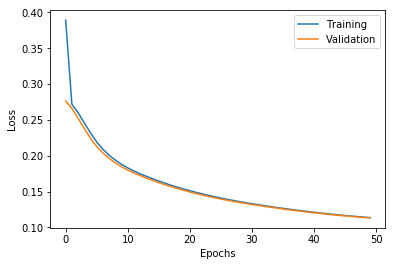

In [10]:
plot_history(history)

Well, not yet done, but we don't have more time....

## Testing the Autoencoder 

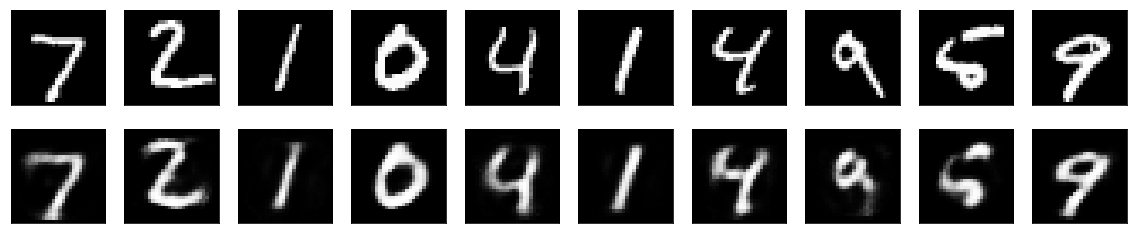

In [11]:
# encode and decode some digitsdecode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

The top row is the original digits, and the bottom row is the reconstructed digits. We are losing quite a bit of detail with this basic approach.

## Sample generation with Autoencoder 

Can we actually generate numbers using the trained decoder, if we just draw random numbers for the encoded image?

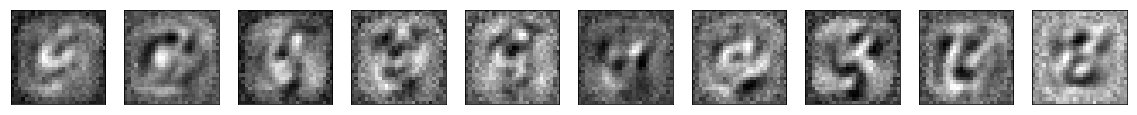

In [12]:
encoded_imgs = np.random.rand(10,32)
decoded_imgs = decoder.predict(encoded_imgs)

n = 10 
plt.figure(figsize=(20, 4))
for i in range(n):
    # generation
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Although you might see some structures which look similar to numbers in the middle, using the decoder as a generator for handwritten digits clearly doesn't work. 

We could now study deeper structures, feel free to try this at home, but the result will only improve slightly. Another way to constrain the representations to be compact is to add a sparsity contraint on the activity of the hidden representations, so fewer units would "fire" at a given time. In Keras, this can be done by adding the L1 norm regularizer as an `activity_regularizer` to our Dense layer.

---

## Convolutional AutoEncoder

Since our inputs are images, it makes sense to use convolutional neural networks (`convnets`) as encoders and decoders. 
In practical settings, autoencoders applied to images are always convolutional autoencoders --they simply perform much better.

The encoder will consist in a stack of `Conv2D` and `MaxPooling2D` layers (max pooling being used for spatial down-sampling), while the decoder will consist in a stack of `Conv2D` and `UpSampling2D` layers.



In [13]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

conv_autoencoder = Model(input_img, decoded)
conv_autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
conv_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 8)           0         
__________

## Task 1: Train and evaluate the Convolutional Autoencoder
* Prepare the data for the Convolutional Autoencoder
* Train the Convolutional Autoencoder and plot the training and validation loss
* Test the Convolutional Autoencoder by plotting 10 of the decoded predictions next to the original images
* Plot the encoded representations in order to visualize how the digits are encoded 

## Data Preparation for Convolutional Autoencoder

In [14]:
from keras import backend as K

if K.image_data_format() == 'channels_last':
    shape_ord = (28, 28, 1)
else:
    shape_ord = (1, 28, 28)
    
#Load
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#Scale
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

#Shape for CNN
x_train = np.reshape(x_train, ((x_train.shape[0],) + shape_ord))  
x_test = np.reshape(x_test, ((x_test.shape[0],) + shape_ord)) 

#Split into validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

In [15]:
x_train.shape

(42000, 28, 28, 1)

## Training the Convolutional Autoencoder

Let's train this model. For the sake of demonstrating how to visualize the results of a model during training, we will be using the TensorFlow backend and the TensorBoard callback.

First, let's open up a terminal and start a TensorBoard server that will read logs stored at `/tmp/autoencoder`.

tensorboard --logdir=/tmp/autoencoder

Then let's train our model. In the callbacks list we pass an instance of the TensorBoard callback. After every epoch, this callback will write logs to /tmp/autoencoder, which can be read by our TensorBoard server.

In [16]:
from keras.callbacks import TensorBoard

history = conv_autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 42000 samples, validate on 10000 samples
Epoch 1/50
42000/42000 [==============================] - 44s 1ms/step - loss: 0.2658 - val_loss: 0.2163
Epoch 2/50
42000/42000 [==============================] - 43s 1ms/step - loss: 0.1949 - val_loss: 0.1834
Epoch 3/50
42000/42000 [==============================] - 45s 1ms/step - loss: 0.1769 - val_loss: 0.1738
Epoch 4/50
42000/42000 [==============================] - 45s 1ms/step - loss: 0.1662 - val_loss: 0.1632
Epoch 5/50
42000/42000 [==============================] - 45s 1ms/step - loss: 0.1577 - val_loss: 0.1488
Epoch 6/50
42000/42000 [==============================] - 44s 1ms/step - loss: 0.1505 - val_loss: 0.1493
Epoch 7/50
42000/42000 [==============================] - 44s 1ms/step - loss: 0.1455 - val_loss: 0.1398
Epoch 8/50
42000/42000 [==============================] - 45s 1ms/step - loss: 0.1407 - val_loss: 0.1558
Epoch 9/50
42000/42000 [==============================] - 45s 1ms/step - loss: 0.1369 - val_loss: 0.1337
Epoch

This allows us to monitor training in the TensorBoard web interface (by navighating to http://0.0.0.0:6006

Tensorboard is pretty cool, you can also have a look at the graphs to see a representation of you model. Using tensorboard is quite useful to understand if your model is working an visualize a few features of your model right in the beginning of your training. This way you know immediately if it is working or not and don't need to wait until the training is done. More information can be found here:

https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard

Let's plot the loss here as well:

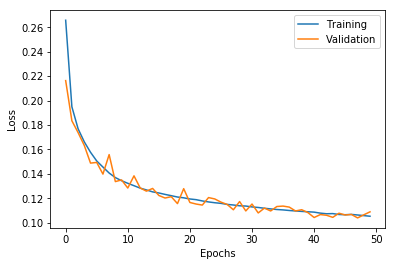

In [17]:
plot_history(history)

The model converges to a loss, which is significantly better than our previous models (this is in large part due to the higher entropic capacity of the encoded representation, 128 dimensions vs. 32 previously). Let's take a look at the reconstructed digits:

## Testing the Convolutional Autoencoder

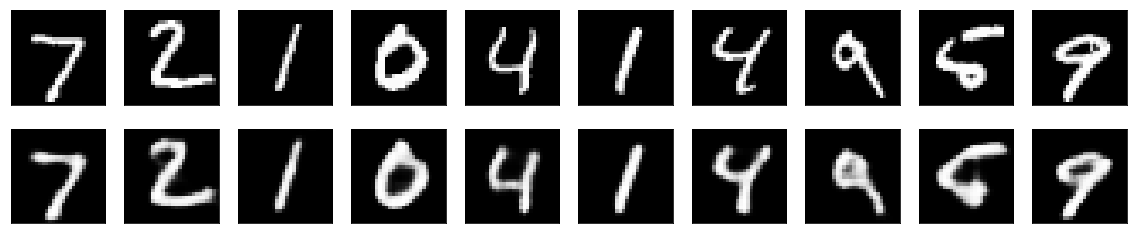

In [18]:
decoded_imgs = conv_autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

We can also have a look at the 128-dimensional encoded representations. These representations are 8x4x4, so we reshape them to 4x32 in order to be able to display them as grayscale images.

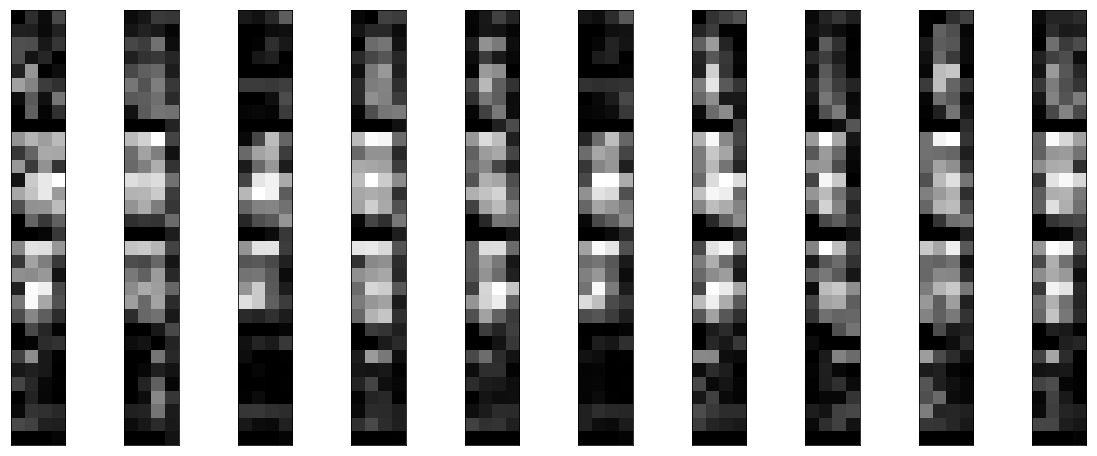

In [19]:
conv_encoder = Model(input_img, encoded)
encoded_imgs = conv_encoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(encoded_imgs[i].reshape(4, 4 * 8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

---

## Application to Image Denoising

Let's put our convolutional autoencoder to work on an image denoising problem. It's simple: we will train the autoencoder to map noisy digits images to clean digits images.

Here's how we will generate synthetic noisy digits: we just apply a gaussian noise matrix and clip the images between 0 and 1.

In [20]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Here's how the noisy digits look like:

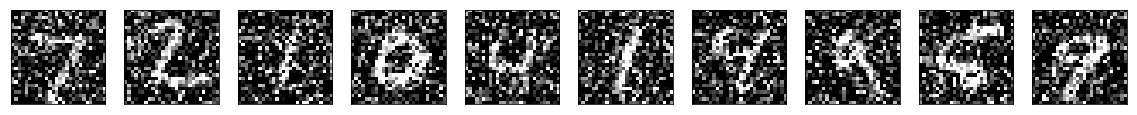

In [21]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

If you squint you can still recognize them, but barely.

## Question: Can our autoencoder learn to recover the original digits?

Compared to the previous convolutional autoencoder, in order to improve the quality of the reconstructed, we'll use a slightly different model with more filters per layer:

In [22]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 14, 14, 32)        0         
__________

Let's train the AutoEncoder

In [23]:
history = autoencoder.fit(x_train_noisy, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder_denoise', 
                                       histogram_freq=0, write_graph=False)])

Train on 42000 samples, validate on 10000 samples
Epoch 1/50
42000/42000 [==============================] - 89s 2ms/step - loss: 0.1972 - val_loss: 0.1317
Epoch 2/50
42000/42000 [==============================] - 96s 2ms/step - loss: 0.1264 - val_loss: 0.1164
Epoch 3/50
42000/42000 [==============================] - 96s 2ms/step - loss: 0.1168 - val_loss: 0.1104
Epoch 4/50
42000/42000 [==============================] - 95s 2ms/step - loss: 0.1123 - val_loss: 0.1097
Epoch 5/50
42000/42000 [==============================] - 94s 2ms/step - loss: 0.1090 - val_loss: 0.1084
Epoch 6/50
42000/42000 [==============================] - 100s 2ms/step - loss: 0.1070 - val_loss: 0.1034
Epoch 7/50
42000/42000 [==============================] - 117s 3ms/step - loss: 0.1056 - val_loss: 0.1027
Epoch 8/50
42000/42000 [==============================] - 142s 3ms/step - loss: 0.1044 - val_loss: 0.1035
Epoch 9/50
42000/42000 [==============================] - 166s 4ms/step - loss: 0.1034 - val_loss: 0.1037
E

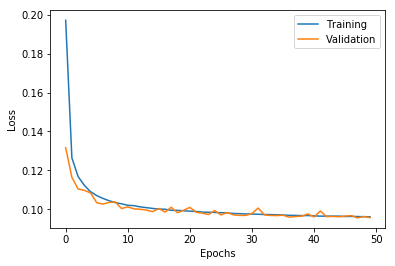

In [24]:
plot_history(history)

Now let's take a look at the results. Top, the noisy digits fed to the network, and bottom, the digits are reconstructed by the network.

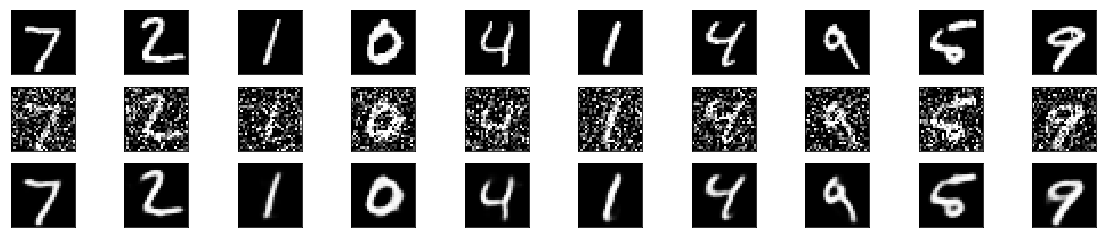

In [44]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)    
    ax = plt.subplot(3, n, i + n + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(3, n, i + 2*n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

It seems to work pretty well. If you scale this process to a bigger convnet, you can start building document denoising or audio denoising models.

# Bonus: Variational AutoEncoder

_Reference [https://blog.keras.io/building-autoencoders-in-keras.html](https://blog.keras.io/building-autoencoders-in-keras.html)_
and https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py


Variational autoencoders are a slightly more modern and interesting take on autoencoding.

### What is a variational autoencoder ? 

It's a type of autoencoder with added constraints on the encoded representations being learned. 

More precisely, it is an autoencoder that learns a [latent variable model](https://en.wikipedia.org/wiki/Latent_variable_model) for its input data. 

So instead of letting your neural network learn an arbitrary function, you are learning the parameters of a probability distribution modeling your data. 

If you sample points from this distribution, you can generate new input data samples: 
a **VAE** is a **"generative model"**.

### How does a variational autoencoder work?

First, an encoder network turns the input samples $x$ into two parameters in a latent space, which we will note $z_{\mu}$ and $z_{log_{\sigma}}$. 

Then, we randomly sample similar points $z$ from the _latent normal distribution_ that is assumed to generate the data, via $z = z_{\mu} + \exp(z_{log_{\sigma}}) * \epsilon$, where $\epsilon$ is a random normal tensor. 

Finally, a decoder network maps these latent space points back to the original input data.

The parameters of the model are trained via two loss functions: 

* a **reconstruction loss** forcing the decoded samples to match the initial inputs (just like in our previous autoencoders);
* and the **KL divergence** between the learned latent distribution and the prior distribution, acting as a regularization term. 

You could actually get rid of this latter term entirely, although it does help in learning well-formed latent spaces and reducing overfitting to the training data.

## Load MNIST

In [26]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

In [27]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

## Encoder Network

First, here's our encoder network, mapping inputs to our latent distribution parameters:


In [28]:
# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

In [29]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

We can use these parameters to sample new similar points from the latent space:

In [30]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_3[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_3[0][0]                    
__________________________________________________________________________________________________
z (Lambda)

## Decoder Network

Finally, we can map these sampled latent points back to reconstructed inputs:

In [31]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1536      
_________________________________________________________________
dense_5 (Dense)              (None, 784)               402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


## Variational AutoEncoder

In [32]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

We train the model using the end-to-end model, with a custom loss function: the sum of a reconstruction term, and the KL divergence regularization term.

In [33]:
reconstruction_loss = binary_crossentropy(inputs,outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
decoder (Model)              (None, 784)               403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________


/media/nackenho/Data/programs/ML/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Output "decoder" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "decoder" during training.
  


Traing on MNIST Digits

In [34]:
history = vae.fit(x_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 17s 276us/step - loss: 196.8490 - val_loss: 172.5153
Epoch 2/50
60000/60000 [==============================] - 13s 210us/step - loss: 170.7229 - val_loss: 168.1144
Epoch 3/50
60000/60000 [==============================] - 12s 202us/step - loss: 167.1706 - val_loss: 165.0273
Epoch 4/50
60000/60000 [==============================] - 13s 222us/step - loss: 164.3275 - val_loss: 162.4907
Epoch 5/50
60000/60000 [==============================] - 11s 187us/step - loss: 162.1700 - val_loss: 161.0101
Epoch 6/50
60000/60000 [==============================] - 13s 212us/step - loss: 160.5360 - val_loss: 159.6353
Epoch 7/50
60000/60000 [==============================] - 13s 211us/step - loss: 159.2461 - val_loss: 158.3681
Epoch 8/50
60000/60000 [==============================] - 13s 211us/step - loss: 158.2196 - val_loss: 157.8768
Epoch 9/50
60000/60000 [==============================] - 15s 

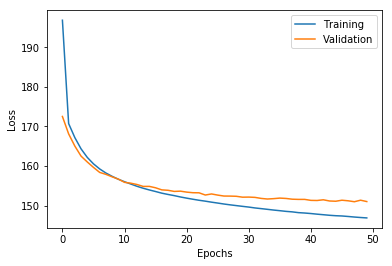

In [35]:
plot_history(history)

Because our latent space is two-dimensional, there are a few cool visualizations that can be done at this point. 

One is to look at the neighborhoods of different classes on the latent 2D plane:

In [36]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)

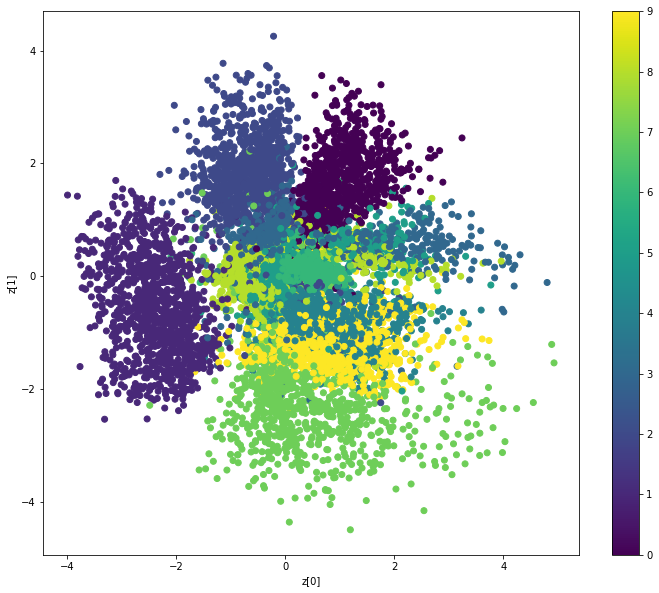

In [45]:
# display a 2D plot of the digit classes in the latent space
z_mean, _, _ = encoder.predict(x_test,
                               batch_size=batch_size)
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap='viridis')
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()


Each of these colored clusters is a type of digit. Close clusters are digits that are structurally similar (i.e. digits that share information in the latent space).


Because the VAE is a generative model, we can also use it to generate new digits! Here we will scan the latent plane, sampling latent points at regular intervals, and generating the corresponding digit for each of these points. This gives us a visualization of the latent manifold that "generates" the MNIST digits.

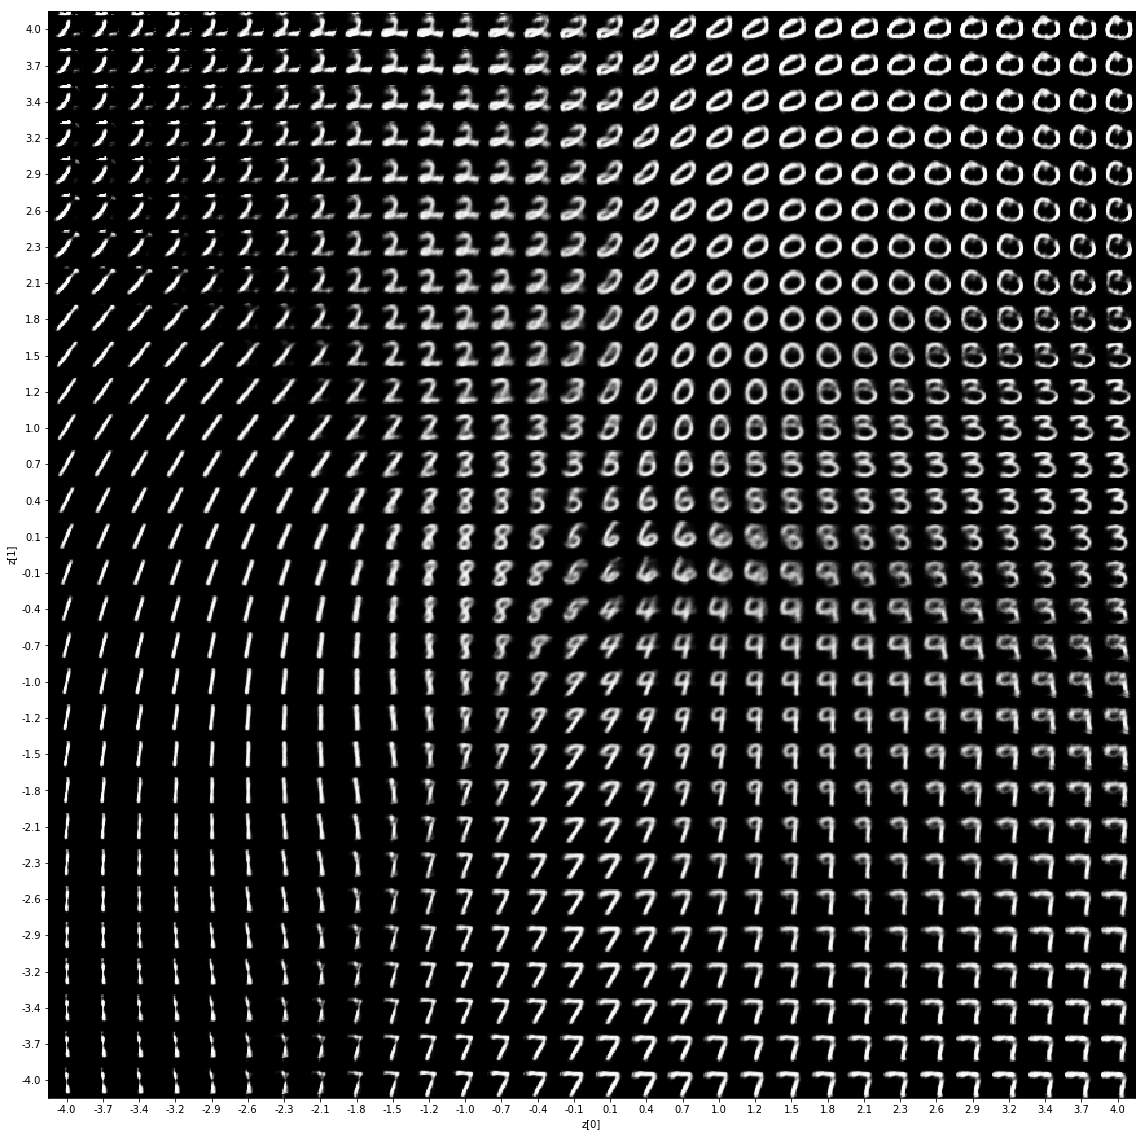

In [38]:
# display a 30x30 2D manifold of digits
n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(20, 20))
start_range = digit_size // 2
end_range = n * digit_size + start_range + 1
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap='Greys_r')
plt.show()